This is a notebook containing the code to my brain decoding tutorial, based on nilearn's introductory tutorial:

https://nilearn.github.io/auto_examples/plot_decoding_tutorial.html

The neuroscience and machine learning concepts are covered in their corresponding files included in the repo. The documentation included here is focused on the inner workings of the code. Please read the `fMRI_Crash_Course.md` and the `ML_Crash_Course.ipynb` files before proceeding!

In [1]:
# TODO: FIND OUT WHY THIS IS NECESSARY

%matplotlib inline

## Downloading the data

If this is the first time you are running this, the `nilearn.datasets.fetch_haxby` function will download subject 2 (by default) from the Haxby dataset into a nilearn created path on your computer. It is about 310 MB of data so it may take a little while to download.

Optional parameters:

- If you wish to specify the directory where the download should take place, you can use the `data_dir` parameter, which takes a string.

- If you wish to retrieve other subjects, use the `subjects` parameter, which takes a list or an int.

In [2]:
from nilearn import datasets

ds = datasets.fetch_haxby()

/Users/normankong/Desktop/decoding/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


What is returned from this function is a nilearn dict-like object containing different 'keys' to different parts of the data. To view, simply run the next cell:

In [ ]:
print(ds)

In the next cell, we will store the paths of:

- the bold file (`bold.nii.gz`, stored in the `func` key)
- A mask of the ventral temporal stream (`mask_vt.nii.gz`, stored in the `mask_vt` key)
- An anatomical image of the subject (`anat.nii.gz`, stored in the `anat` key)
- The labels of each image (`labels.txt`, stored in the `session_target` key)

so that we can easily refer to them. Note that the paths are stored in lists, so we must access them by index.

In [3]:
bold_path = ds.func[0]
mask_path = ds.mask_vt[0]
anat_path = ds.anat[0]
labels_path = ds.session_target[0]

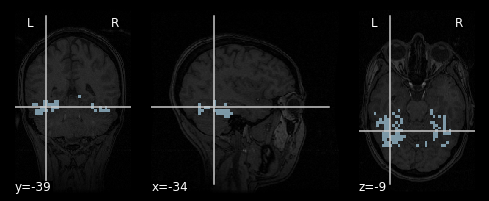

In [4]:
# Here, we will quickly take a look at the mask, overlaid onto the subject's 
# anatomical image

from nilearn import plotting

# TODO: what is cmap='Paired' ??
plotting.plot_roi(mask_path, bg_img=anat_path, cmap='Paired')

## Converting the Mask to a Usable Matrix

Nilearn's "masker" object converts raw data (ie, a NIfTI file) into a usable format (ie, a numerical matrix). Please note that masker objects apply some basic preprocessing steps with common parameters by default. All preprocessing is outside the scope of this tutorial, but _may_ be added in the future. 

In [5]:
from nilearn.input_data import NiftiMasker

# We must first create a masker object in order to use it's class methods
masker = NiftiMasker(mask_img=mask_path, standardize=True)

# Standardizing the data is also done.
# TODO: Why is standardizing necessary/beneficial?

# Creating a numpy matrix from the BOLD data, using the mask for the transformation
bold_masked = masker.fit_transform(bold_path)

The `bold_masked` file is a numpy matrix containing the BOLD data, after having the mask transformation applied. 

Note: `bold_masked` will be masked twice: the first time, to keep only the voxels related to the ventral temporal stream, and a second time when we want only the BOLD signal related to faces and cats.

In [21]:
# Viewing the dimensions of the matrix
# The shape represents the number of time-stamps by the number of voxels in the mask, 
# For clarity, that means: 1452 time-stamps and 464 voxels
print(bold_masked.shape)

# Printing a newline for clarity
print()

# Viewing the numerical values of the matrix
print(bold_masked)

(216, 464)

[[ 1.2603112   1.9578872   0.2073549  ... -0.9613675  -0.675308
   2.717232  ]
 [ 1.1899209   2.0363278   0.49613947 ... -1.0261141  -0.7793945
   2.717232  ]
 [ 1.506677    2.0755484   0.6199043  ... -0.8966208  -0.7793945
   2.4136183 ]
 ...
 [-0.28827515 -1.4542887  -0.3289593  ... -1.9973137   2.0135949
   0.74374354]
 [ 0.13406655 -2.0033746  -0.41146913 ... -1.511714    1.5972487
   0.74374354]
 [-0.25308    -1.9641542  -0.5764889  ... -1.7059538   1.5972487
   0.4401299 ]]


In [22]:
# Load the labels from a csv into an array using pandas

import pandas as pd

condtions = pd.read_csv(labels_path, sep=' ')

In [23]:
# Viewing the dimensions of the matrix
print(targets.shape)
# The first dimension is the number of time-stamps, and the second dimension contains the labels and the chunks.

# TODO: What is chunks?

# Printing a newline for clarity
print()

# Viewing the numerical values of the matrix
print(targets)

(1452,)

0       rest
1       rest
2       rest
3       rest
4       rest
        ... 
1447    rest
1448    rest
1449    rest
1450    rest
1451    rest
Name: labels, Length: 1452, dtype: object


We are only interested in the labels, so let's pick those out from the `targets` array.

In [24]:
targets = conditions['labels']

Now, we have isolated the prediction targets in the `targets` variable.

In [25]:
print(targets)

0       rest
1       rest
2       rest
3       rest
4       rest
        ... 
1447    rest
1448    rest
1449    rest
1450    rest
1451    rest
Name: labels, Length: 1452, dtype: object


For this tutorial, we will restrict the analysis to differentiate only between faces and cats. For this, we will use pandas' `DataFrame.isin(self, values)` function. This will return a new `DataFrame` of booleans (in our case, `targets_mask`) showing whether the value(s) in the `values` argument (in our case, `'face'` and `'cat'`) is contained within the `DataFrame` (in our case, `targets`). 

In [13]:
targets_mask = targets.isin(['face', 'cat'])

Given that the returned DataFrame contains only boolean values, we use it as a mask, because it indicates which values we are interested in (ie, `False` for samples we don't care about, and `True` for samples that we do care about; that is, for samples where the subject was shown faces or cats).

In [14]:
print(targets_mask)

0       False
1       False
2       False
3       False
4       False
        ...  
1447    False
1448    False
1449    False
1450    False
1451    False
Name: labels, Length: 1452, dtype: bool


We will now apply this mask so that the BOLD data will only contain the scans relevant to faces and cats.

In [15]:
bold_masked = bold_masked[targets_mask]

`bold_masked` now contains less samples, because we are only looking at the samples where the subject is looking at a face or a cat.

In [16]:
bold_masked.shape

(216, 464)

We have to also apply this mask to our labels matrix.

In [17]:
targets_masked = targets[targets_mask]

In [28]:
print(targets_masked.shape)
print(targets_masked)

(216,)
21      face
22      face
23      face
24      face
25      face
        ... 
1427     cat
1428     cat
1429     cat
1430     cat
1431     cat
Name: labels, Length: 216, dtype: object


## Training Machine Learning Models

Now that our data is in a format that we can work with, it is time to train some models.

For this section, we will be using the sci-kit learn library.

***
Note that 'opt' is short for 'optional', and 'req' is short for 'required'.
***
Note: I have briefly explained what each parameter does, but for an exhaustive list of the possibilities, please see the documentation listed below.

### k-Nearest Neighbours

1. Split data into testing and training sets
2. Fit the model
3. Make predictions, and compute accuracy

First, we'll shuffle the data, then dedicate 70% of it for training, and 30% of it for testing. This is done using sklearn's `train_test_split` method. The method call in this tutorial is as follows:

`train_test_split(bold_masked, targets_masked, test_size=0.3, random_state=42, shuffle=True)`

- `bold_masked`: the samples of the data.
- `targets_masked`: the labels of the data.
- `test_size`: the proportion of the dataset to be used for the testing.
- `random_state`: this is the seed which is used by the random number generator. if it is defined by the user, you will keep the same random state every time it is run. 
- `shuffle`: Whether or not to shuffle the data before splitting. This is recommended in order to not have biased training and testing sets.

Returns: This will return 2 times as many matrices you give it. In this example, we gave it 2 matrices (`bold_masked` and `targets_masked`) and so we are returned 4 matrices, which are our training samples, testing samples, training labels and testing labels, all contained within their own lists. These are defined using list unpacking.

In [97]:
# Shuffling the data then splitting it into 70-30 split 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(bold_masked, targets_masked, test_size=0.3, random_state=42, shuffle=True)

Now, it is time to create our model. We do this by creating a `KNeighborsClassifier()` object, which has the fit and predict methods.

This object has several parameters, explained here:

- `algorithm` (opt, str, default=`'auto'`): The algorithm used to compute the nearest neighbors. These include: `ball_tree`, `kd_tree`, `brute` and `auto`. 
- `leaf_size` (opt, str, default='30'): The leaf size passed to BallTree or KDTree. 
- `metric` (opt, str or callable, default=`'minkowski'`): The metric (or function) to use to compute the distance between points.
- `metric_params`(opt, dict, default=`None`): Additional keyword arguments for the metric function. 
- `n_jobs`(opt, int, default=`None`): The number of cores utilized for for the neighbours search. 
- `n_neighbours`(opt, int, default=5): The number of neighbours to use to determine the label.
- `p` (opt, int, default=2): The power parameter for the Minkowski metric.
- `weights`: The weight function to be used in prediction. That is, you can decide how the closest points to the unknown point are weighed. If unspecified, the default is `'uniform'`, which means all neighbouring points are weighted equally.

In [107]:
# Create and fit (train) a nearest-neighbor classifier
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

The `fit` method is a general sci-kit learn method that usually trains the model on the training data. However, kNNs don't really "train" and so in this class, all this method does is store the training samples and labels in memory. 

In [112]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Now, let's see how well our model does! First, we'll store its predictions in a variable called `y_pred`.

In [118]:
y_pred = knn.predict(X_test)

Then, we can use sklearn's `accuracy_score` method to see the percentage of labels our model predicted correctly.

In [117]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9384615384615385

### Logistic Regression

AttributeError: 'KNeighborsClassifier' object has no attribute 'get_metric'

And that's it! This tutorial really covers the most basic cases of machine learning, but I highly recommend you tamper with the parameters, and even try your own models! As you've seen, scikit learn makes it extremely easy to start playing with different models and parameters.

Documentation:

Preparing the data:
https://nilearn.github.io/auto_examples/plot_decoding_tutorial.html

***

**k-Nearest Neighbours**:

`train_test_split`:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

`KNeighborsClassifier()`:
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

`accuracy_score`:
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

**Logistic Regression**:

**Support Vector Machine**:

**Convolutional Neural Network**: